# Advanced Lane Finding Project

***
The goals/steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Defining a New Object From AdvancedLaneFinder Class

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import logging
%matplotlib inline

from Advanced_Lane_Finder import *
size = (720, 1280)


lane_finder = AdvancedLaneFinder(image_size = (720, 1280),
                chessboard_image_dir = 'camera_cal',
                gradient  =(7, 50,100),
                magnitude =(7, 60,100),
                direction = (15, 0.5, 1),
                s_channel_thresh= (200,255),
                h_channel_thresh =(20, 100),
                region_interest=np.array([[(100,720), (1150,720), (700, 390)]], dtype = np.int32),
                source_points = np.float32([[532, 496], [756, 496], [288, 664], [1016, 664] ]), 
                dest_points = np.float32([[288, 464], [1016, 464], [288, 664 ], [1016, 664]]), 
                ym_per_pix = 30/720, 
                xm_per_pix = 3.7/700, 
                sliding_window_param = (9, 50, 150),
                n_max_failure = 10)
            
            
OUTPUT_IMAGE_DIR = "output_images"
OUTPUT_VIDEO_DIR = "output_videos"

# Testing The Pipeline

In [15]:
#Camera Calibration 
lane_finder.camera_calibration()

#Testing the pipline process on test images 
images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    # Undistorting the image
    undistorted = lane_finder.distortion_correction(img)
    
    #Color transform and gradient thresholds
    combined_binary = lane_finder.CombinedThresholds(undistorted)
    
    # For each thresholded test image apply region masking
    reg_sel = lane_finder.region_select(combined_binary)
    
    # Perspective transform
    warped = lane_finder.warp(reg_sel)
    
    #Finding the lines
    lane_finder.left_line.detected = False
    lane_finder.right_line.detected = False
    out_img = lane_finder.fit_polynomial(warped, draw = 'Yes') 

    # Finding the lane curvature
    lane_finder.measure_curvature_real()

    # Finding the vehicle position respect to the lane centerline
    lane_finder.bias()
  
    # Output visual display of the lane boundaries
    warped_lane = lane_finder.warp_display(warped)
    
    # Warp the detected lane boundaries back onto the original image   
    img_final = lane_finder.Lane_display(img, warped_lane)
    
    # Writting on the image
    lane_finder.addText(img_final)
    
        
    # create output directory for images, if does not exist
    if not os.path.isdir(OUTPUT_IMAGE_DIR):
        os.mkdir(OUTPUT_IMAGE_DIR)
 
    cv2.imwrite(os.path.join(OUTPUT_IMAGE_DIR, "test"+ str(idx+1)+"_Processed.jpg"), img_final)
    

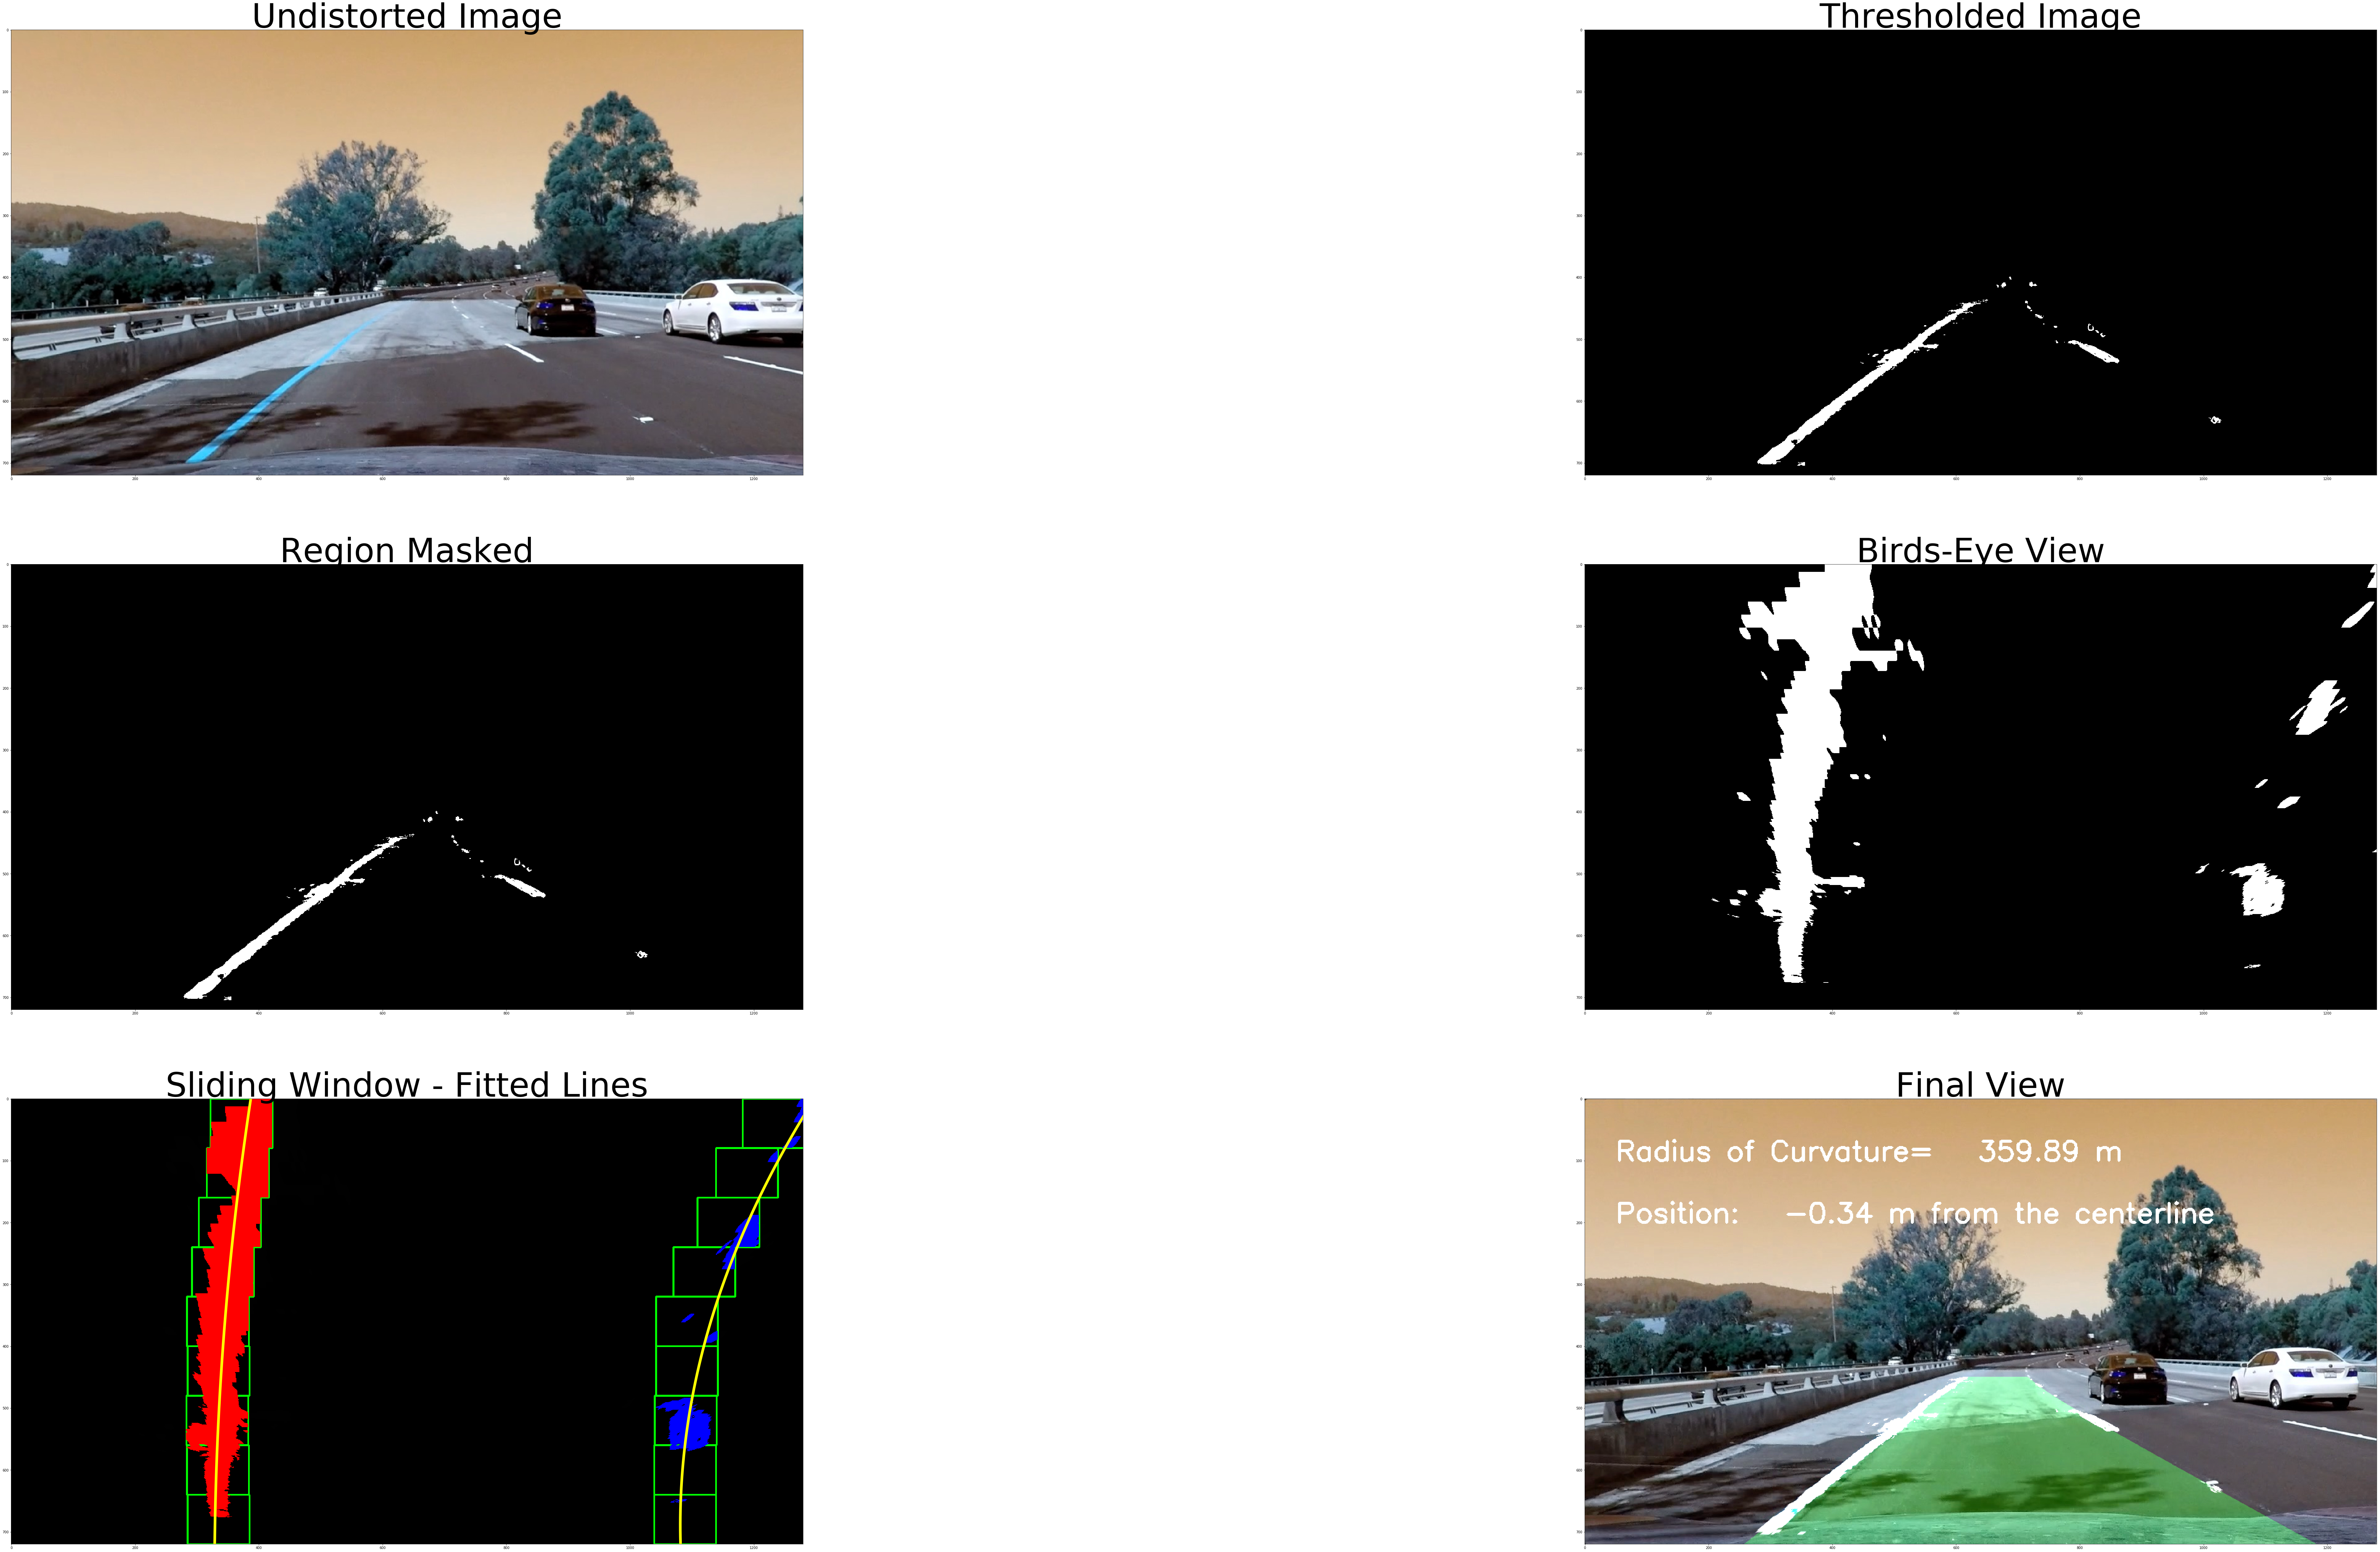

In [19]:
# Plotting the resulted images
f, axes = plt.subplots(3, 2, figsize=(120,70))
axes[0, 0].imshow(undistorted)
axes[0, 0].set_title('Undistorted Image', fontsize=100)

axes[0, 1].imshow(combined_binary, cmap = 'gray')
axes[0, 1].set_title('Thresholded Image', fontsize=100)

axes[1, 0].imshow(reg_sel, cmap='gray')   
axes[1, 0].set_title('Region Masked', fontsize=100)

axes[1, 1].imshow(warped, cmap='gray')   
axes[1, 1].set_title('Birds-Eye View', fontsize=100)

axes[2, 0].imshow(out_img)
axes[2, 0].autoscale(False)
axes[2, 0].plot(lane_finder.left_line.allx , lane_finder.ploty, linewidth=8.0, color = 'yellow')
axes[2, 0].plot(lane_finder.right_line.allx , lane_finder.ploty, linewidth=8.0, color = 'yellow')
axes[2, 0].set_title('Sliding Window - Fitted Lines', fontsize=100)

axes[2, 1].imshow(img_final)   
axes[2, 1].set_title('Final View', fontsize=100)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Processing the Video

In [4]:
def process_image(image):

    #Camera Calibration
    if lane_finder.calibration_matrix == None: 
        lane_finder.camera_calibration()
        
    # Undistorting the image
    undistorted = lane_finder.distortion_correction(image)
    
    # Color and gradient threshold
    combined_binary =  lane_finder.CombinedThresholds(undistorted)
    
    # Region Masking
    img = lane_finder.region_select(combined_binary)

    #Perspective transform
    warped = lane_finder.warp(img)
    
    # Finding the lane polynomial
    lane_finder.fit_polynomial(warped, draw = 'No')
    
    # Finding the lane curvature
    lane_finder.measure_curvature_real()

    # Finding the vehicle position respect to the lane centerline
    lane_finder.bias()
    
    # Lane display on original image
    warped_lane = lane_finder.warp_display(warped)
    img_final = lane_finder.Lane_display(undistorted, warped_lane)
    
    # Writting on the image
    lane_finder.addText(img_final)
    
    return img_final

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
white_output = 'output_images/output_video5.mp4'
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

  after removing the cwd from sys.path.



[MoviePy] >>>> Building video output_images/output_video5.mp4
[MoviePy] Writing video output_images/output_video5.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  after removing the cwd from sys.path.

100%|█████████▉| 1260/1261 [07:47<00:00,  2.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output_video5.mp4 

CPU times: user 5min 34s, sys: 2.41 s, total: 5min 36s
Wall time: 7min 50s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))